In [47]:
!pip3 install cython
!pip3 install tensornets

In [48]:
!pip install ipywidgets

### **Importing modules**

In [49]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from keras import applications as ap
import IPython.display
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
from PIL import Image,ImageTk
import os
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [50]:
# Ensure TensorFlow is running in eager mode
tf.config.run_functions_eagerly(True)

In [51]:
def load_img(path):
    input_size = (224, 224)
    img = Image.open(path)
    img = img.resize(input_size, Image.ANTIALIAS)
    img = np.array(img)[...,:3]
    img = img.astype('float32')
    return img

In [52]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68
    img = img[:, :, ::-1]
    img = np.expand_dims(img, axis=0)
    return img

In [53]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### **Load VGG19 model pre-trained on ImageNet**

In [54]:
vgg = VGG19(weights='imagenet', include_top=False)

### **Defining Content and Style layers from pretrained model**

In [55]:
# Define the model to output content and style layer activations
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

In [56]:
output_layers = style_layers + content_layers
model_outputs = [vgg.get_layer(name).output for name in output_layers]
model = Model(inputs=vgg.input, outputs=model_outputs)

In [57]:
def get_feature_representations(model, content_path, style_path):
    # Load and process the content and style images
    # This function likely loads the image from the given path and processes it into a format compatible with the model
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # Compute content and style features
    # Pass the style image through the model to get the style features
    style_outputs = model(style_image)
    # Pass the content image through the model to get the content features
    content_outputs = model(content_image)

    # Extract the features for the style layers from the model outputs
    # Assuming style_layers contains the indices of layers that capture style features
    style_features = [style_layer for style_layer in style_outputs[:len(style_layers)]]
    # Extract the features for the content layers from the model outputs
    # Assuming content layers are after the style layers in the model outputs
    content_features = [content_layer for content_layer in content_outputs[len(style_layers):]]

    return style_features, content_features


### **Compute Gram matrix**

In [58]:

def compute_gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    return tf.matmul(a, a, transpose_a=True) / tf.cast(n * n, tf.float32)


### **Style Loss**

In [59]:
def get_style_loss(style_features, style_outputs):
    style_loss = 0
    for style_feature, style_output in zip(style_features, style_outputs):
        gram_style = compute_gram_matrix(style_feature)
        gram_output = compute_gram_matrix(style_output)
        style_loss += tf.reduce_sum(tf.square(gram_style - gram_output)) / tf.cast(4 * (style_feature.shape[0] ** 2), tf.float32)
    return style_loss / len(style_features)

### **Content Loss**

In [60]:
def get_content_loss(content_feature, content_output):
    return tf.reduce_mean(tf.square(content_feature - content_output))

### **Total Loss**

In [61]:
#calculating total loss
def get_total_loss(model, loss_weights, init_image, gram_style_features, content_feature):
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:len(style_layers)]
    content_output_feature = model_outputs[len(style_layers):]

    style_score = get_style_loss(gram_style_features, style_output_features)
    content_score = get_content_loss(content_feature, content_output_feature[0])

    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score
    return loss, style_score, content_score

### **File upload widgets**

In [62]:
upload_content = widgets.FileUpload(accept='image/*', multiple=False)
upload_style = widgets.FileUpload(accept='image/*', multiple=False)

In [63]:
def on_upload_change(change):
    global content_img, style_img, content_path, style_path

    if upload_content.value and upload_style.value:  # Check if both content and style images are uploaded
        content_file = list(upload_content.value.values())[0]  # Get the uploaded content image file
        style_file = list(upload_style.value.values())[0]  # Get the uploaded style image file

        content_path = 'uploaded_content.jpg'  # Set the path for the uploaded content image
        style_path = 'uploaded_style.jpg'  # Set the path for the uploaded style image

        with open(content_path, 'wb') as f:  # Write the content image to a file
            f.write(content_file['content'])

        with open(style_path, 'wb') as f:  # Write the style image to a file
            f.write(style_file['content'])

        content_img = load_and_process_img(content_path)  # Load and process the content image
        style_img = load_and_process_img(style_path)  # Load and process the style image

        display_images(content_path, style_path)  # Display the content and style images

        # Proceed with style transfer
        perform_style_transfer()  # Perform style transfer using the processed images


In [64]:
def display_images(content_path, style_path):
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    content_image = Image.open(content_path)
    style_image = Image.open(style_path)
    ax[0].imshow(content_image)
    ax[0].set_title('Content Image')
    ax[1].imshow(style_image)
    ax[1].set_title('Style Image')
    plt.show()

In [65]:
def perform_style_transfer():
    # Get the style and content feature representations from the model
    style_features, content_features = get_feature_representations(model, content_path, style_path)

    # Initialize the image to be optimized with the content image
    init_image = tf.Variable(content_img, dtype=tf.float32)

    # Define the optimizer
    opt = Adam(learning_rate=10.0)

    # Set the number of epochs and steps per epoch for training
    epochs = 20
    steps_per_epoch = 100

    # Define the weights for style and content loss
    style_weight = 1e-2
    content_weight = 1e3
    loss_weights = (style_weight, content_weight)

    for epoch in range(epochs):  # Loop over epochs
        for step in range(steps_per_epoch):  # Loop over steps within an epoch
            with tf.GradientTape() as tape:  # Record operations for automatic differentiation
                # Calculate the total loss
                all_loss = get_total_loss(model, loss_weights, init_image, style_features, content_features[0])

            total_loss = all_loss[0]  # Extract total loss
            content_loss = all_loss[2]  # Extract content loss
            style_loss = all_loss[1]  # Extract style loss

            # Calculate gradients of the loss with respect to the initialized image
            grad = tape.gradient(total_loss, init_image)
            # Apply gradients to the initialized image
            opt.apply_gradients([(grad, init_image)])

        # Print the loss values every epoch
        print(f"Epoch {epoch}, TotalLoss: {total_loss}, StyleLoss: {style_loss}, ContentLoss: {content_loss}")
        # Display the current state of the image
        IPython.display.display_png(Image.fromarray(deprocess_img(init_image.numpy())))

    # Deprocess and show the final stylized image
    final_img = deprocess_img(init_image.numpy())
    plt.imshow(final_img)
    plt.show()

### **Upload Function**

In [66]:
upload_content.observe(on_upload_change, names='value')
upload_style.observe(on_upload_change, names='value')

### **Display Uploaded Images**

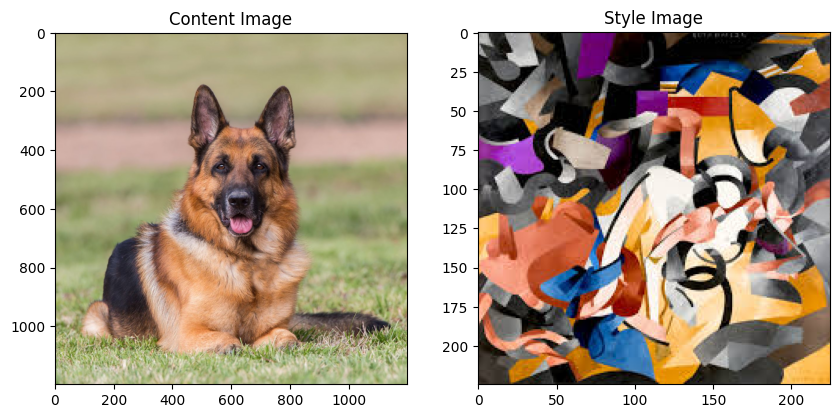

Epoch 0, TotalLoss: 4384674.0, StyleLoss: 2137735.25, ContentLoss: 2246938.5


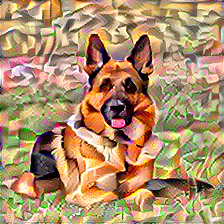

Epoch 1, TotalLoss: 3360193.25, StyleLoss: 1661273.375, ContentLoss: 1698919.875


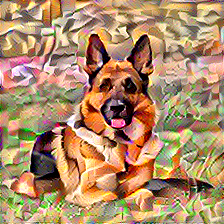

Epoch 2, TotalLoss: 2914236.0, StyleLoss: 1465989.875, ContentLoss: 1448246.25


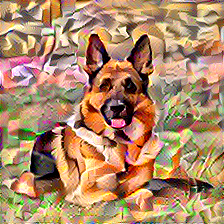

Epoch 3, TotalLoss: 2816547.0, StyleLoss: 1508658.375, ContentLoss: 1307888.625


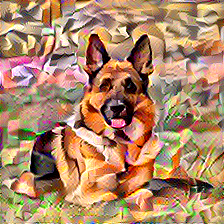

Epoch 4, TotalLoss: 2968204.0, StyleLoss: 1586336.75, ContentLoss: 1381867.25


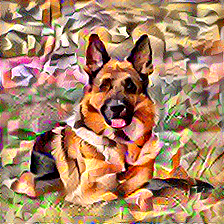

Epoch 5, TotalLoss: 2475736.5, StyleLoss: 1296234.875, ContentLoss: 1179501.625


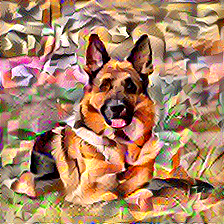

Epoch 6, TotalLoss: 2442219.25, StyleLoss: 1324527.125, ContentLoss: 1117692.125


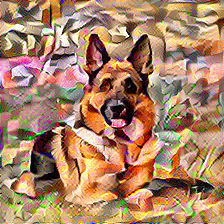

Epoch 7, TotalLoss: 2471943.5, StyleLoss: 1336626.75, ContentLoss: 1135316.75


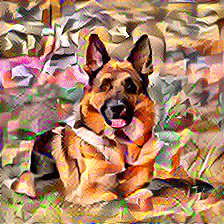

Epoch 8, TotalLoss: 2288511.25, StyleLoss: 1214135.625, ContentLoss: 1074375.625


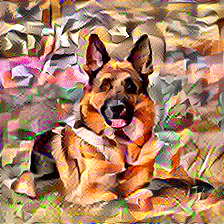

Epoch 9, TotalLoss: 4073098.75, StyleLoss: 2320612.75, ContentLoss: 1752486.0


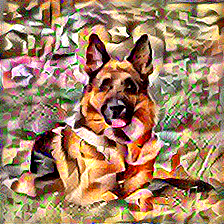

Epoch 10, TotalLoss: 2532820.75, StyleLoss: 1342325.625, ContentLoss: 1190495.125


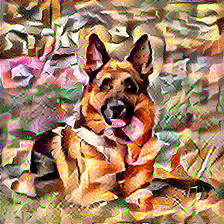

Epoch 11, TotalLoss: 2361837.0, StyleLoss: 1253776.625, ContentLoss: 1108060.25


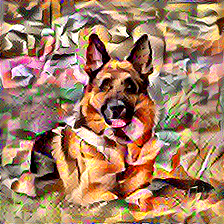

Epoch 12, TotalLoss: 2325404.5, StyleLoss: 1250261.75, ContentLoss: 1075142.625


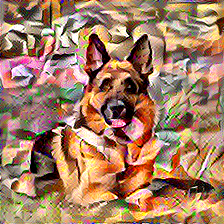

Epoch 13, TotalLoss: 2292009.5, StyleLoss: 1237317.625, ContentLoss: 1054691.75


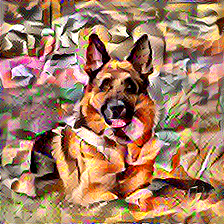

Epoch 14, TotalLoss: 2491696.5, StyleLoss: 1494087.375, ContentLoss: 997609.1875


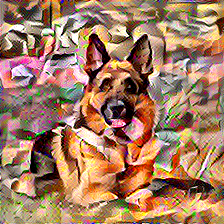

Epoch 15, TotalLoss: 3142606.5, StyleLoss: 2123889.5, ContentLoss: 1018717.0


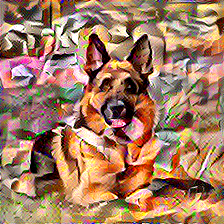

Epoch 16, TotalLoss: 2396836.0, StyleLoss: 1319664.625, ContentLoss: 1077171.25


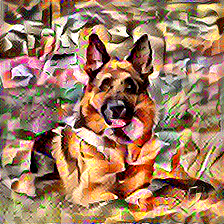

Epoch 17, TotalLoss: 2216854.5, StyleLoss: 1213771.75, ContentLoss: 1003082.8125


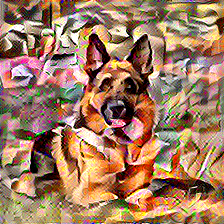

Epoch 18, TotalLoss: 2155265.75, StyleLoss: 1184102.25, ContentLoss: 971163.4375


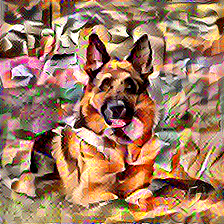

Epoch 19, TotalLoss: 2113651.0, StyleLoss: 1163828.0, ContentLoss: 949822.9375


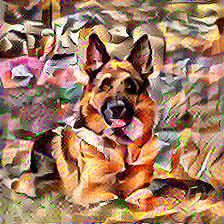

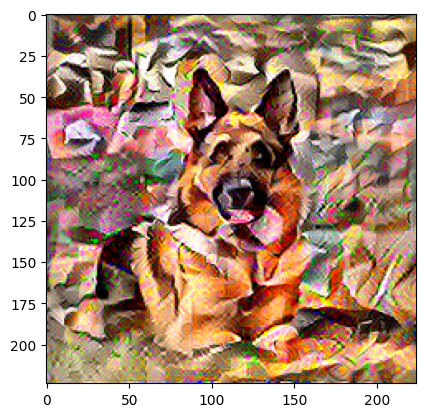

In [67]:
display(widgets.VBox([widgets.Label("Upload Content Image"), upload_content,
                      widgets.Label("Upload Style Image"), upload_style]))